<a href="https://colab.research.google.com/github/BiancadeFrancisco/Cluesterizacao_CopaMundo/blob/main/Clusteriza%C3%A7%C3%A3o_HIERARQUICA_CASE_COPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contextualização

## **Objetivo geral:**

- Agrupar países dado seus respectivos desempenhos nas copas de 1930 a 2018, **utilizando a técnica de clusterização hierárquica**.

**Dataset:**

Os dados foram coletados através [deste link](https://www.kaggle.com/datasets/iamsouravbanerjee/fifa-football-world-cup-dataset) e contém vários arquivos csv, um para cada copa mundial, mais um arquivo de resumo das copas (que não será utilizado neste case).

Dicionário dos dados:

|Variável         | Descrição|
|:----------------|:---------|
|Position         | Posição (rank da copa) |
|Team             | Time |
|Games Played     | Quantidades de jogos na copa que o time participou |
|Win              | Quantidade de jogos na copa que o time ganhou |
|Draw             | Quantidade de jogos na copa que o time empatou |
|Loss             | Quantidade de jogos na copa que o time perdeu |
|Goals For        | Quantidade de gols feitos pelo time na copa |
|Goals Against    | Quantidade de gols recebidos contra o time na copa |
|Goals Difference | Quantidade de gols feitos menos a quantidade de gols recebidos |
|Points           | Pontos do time na copa |


## **Instruções**

- Faça um pré-processamento dos dados, de forma que os dados fiquem comparáveis entre os times.
- Plot um dendrograma testando diferentes métodos da abordagem bottom-up e inspecione os gráficos, tirando suas conclusões.
- Avalie a quantidade "ideal" de cluster pelas métricas estudadas no módulo.
- Escolha uma quantidade de grupos e descreva os grupos estudados, bem como os times presentes em cada grupo.

**Considere apenas os times que participaram de mais de 3 copas.**

In [ ]:
import re
import glob
import numpy as np
import pandas as pd

from ipywidgets import interact
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import MinMaxScaler, minmax_scale, scale
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# CARACTERÍSTICAS IMAGENS GRÁFICAS

sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize':(12,8),
        'axes.grid':True,
        'grid.alpha':.2,
        'axes.labelpad':10,
        'axes.titlepad': 30
    }
)

In [ ]:
# FUNÇÃO PARA O DATASET

def read_csv_custom(file):
  df = pd.read_csv(file)
  df['Year'] = int(re.search('\d+', file).group())
  return df

## Load data

In [ ]:
# Download and unzip files

!wget https://github.com/cmcouto-silva/datasets/raw/main/datasets/fifa-football-world-cup-dataset.zip
!unzip fifa-football-world-cup-dataset.zip

--2023-07-31 14:04:09--  https://github.com/cmcouto-silva/datasets/raw/main/datasets/fifa-football-world-cup-dataset.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cmcouto-silva/datasets/main/datasets/fifa-football-world-cup-dataset.zip [following]
--2023-07-31 14:04:09--  https://raw.githubusercontent.com/cmcouto-silva/datasets/main/datasets/fifa-football-world-cup-dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13531 (13K) [application/zip]
Saving to: ‘fifa-football-world-cup-dataset.zip’

fifa-football-world 100%[===================>]  13.21K  --.-KB/s    in 0s      

2023-07

In [ ]:
# Listando arquivos com

files = glob.glob(r'FIFA - [1-2]*')


In [ ]:
df_teams = pd.concat([read_csv_custom(file) for file in files])
df_teams = df_teams.sort_values(['Year','Position'])
display(df_teams)

,Position,Team,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points,Year
0,1,Uruguay,4,4,0,0,15,3,12,8,1930
1,2,Argentina,5,4,0,1,18,9,9,8,1930
2,3,United States,3,2,0,1,7,6,1,4,1930
3,4,Yugoslavia,3,2,0,1,7,7,0,4,1930
4,5,Chile,3,2,0,1,5,3,2,4,1930
...,...,...,...,...,...,...,...,...,...,...,...
27,28,Costa Rica,3,0,1,2,2,5,−3,1,2018
28,29,Iceland,3,0,1,2,2,5,−3,1,2018
29,30,Morocco,3,0,1,2,2,4,−2,1,2018
30,31,Egypt,3,0,0,3,2,6,−4,0,2018


# Pré-processamento

ADICIONANDO NOVAS COLUNAS PARA QUE OS DADOS FIQUEM COMPARÁVEIS:

In [ ]:
df_teams = (
  df_teams
 .assign(**{
     'Win %': lambda x: x['Win'] / x['Games Played'],
     'Draw %': lambda x: x['Draw'] / x['Games Played'],
     'Loss %': lambda x: x['Loss'] / x['Games Played'],
     'Avg Goals For': lambda x: x['Goals For'] / x['Games Played'],
     'Avg Goals Against': lambda x: x['Goals For'] / x['Games Played'],
     'Normalized Rank': lambda x: x.Position.rank(pct=True, ascending=False),
     'Normalized Points': lambda x: x.Points.rank(pct=True, ascending=False),
     'Century': lambda x: (x.Year // 100 + 1).astype(str)
 })
)

display(df_teams)

,Position,Team,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points,Year,Win %,Draw %,Loss %,Avg Goals For,Avg Goals Against,Normalized Rank,Normalized Points,Century
0,1,Uruguay,4,4,0,0,15,3,12,8,1930,1.000000,0.000000,0.000000,3.750000,3.750000,0.978118,0.183807,20
1,2,Argentina,5,4,0,1,18,9,9,8,1930,0.800000,0.000000,0.200000,3.600000,3.600000,0.932166,0.183807,20
2,3,United States,3,2,0,1,7,6,1,4,1930,0.666667,0.000000,0.333333,2.333333,2.333333,0.886214,0.456236,20
3,4,Yugoslavia,3,2,0,1,7,7,0,4,1930,0.666667,0.000000,0.333333,2.333333,2.333333,0.840263,0.456236,20
4,5,Chile,3,2,0,1,5,3,2,4,1930,0.666667,0.000000,0.333333,1.666667,1.666667,0.794311,0.456236,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,28,Costa Rica,3,0,1,2,2,5,−3,1,2018,0.000000,0.333333,0.666667,0.666667,0.666667,0.059081,0.818381,21
28,29,Iceland,3,0,1,2,2,5,−3,1,2018,0.000000,0.333333,0.666667,0.666667,0.666667,0.045952,0.818381,21
29,30,Morocco,3,0,1,2,2,4,−2,1,2018,0.000000,0.333333,0.666667,0.666667,0.666667,0.033917,0.818381,21
30,31,Egypt,3,0,0,3,2,6,−4,0,2018,0.000000,0.000000,1.000000,0.666667,0.666667,0.020788,0.937637,21


Agrupando os dados por time, considerando apeans aquelas com mais de 3 copas:

In [ ]:
df_teams_stats = df_teams.groupby('Team').agg(
  n_cups = ('Team', 'count'),
  n_games = ('Games Played', 'sum'),
  avg_wins_per_game = ('Win %', 'mean'),
  avg_draws_per_game = ('Draw %', 'mean'),
  avg_losses_per_game = ('Loss %', 'mean'),
  # avg_points = ('Normalized Points', 'mean'),
  avg_goals_for = ('Avg Goals For', 'mean'),
  # avg_goals_against = ('Avg Goals Against', 'mean'),
  avg_rank = ('Normalized Rank', 'mean')
)

df_teams_stats = df_teams_stats.query('n_cups > 3')
display(df_teams_stats)

,n_cups,n_games,avg_wins_per_game,avg_draws_per_game,avg_losses_per_game,avg_goals_for,avg_rank
Team,,,,,,,
Algeria,4,13,0.229167,0.229167,0.541667,0.937500,0.256838
Argentina,17,81,0.481653,0.173950,0.344398,1.670588,0.691402
Australia,5,16,0.116667,0.250000,0.633333,0.783333,0.194530
Austria,7,29,0.361905,0.171429,0.466667,1.378571,0.544701
Belgium,13,48,0.302015,0.191209,0.506777,1.356410,0.537788
Brazil,21,109,0.626871,0.145805,0.227324,2.073016,0.813848
Bulgaria,6,23,0.071429,0.329365,0.599206,0.599206,0.397155
Cameroon,7,23,0.133333,0.333333,0.533333,0.723810,0.209284
Chile,9,33,0.296296,0.222222,0.481481,1.166667,0.540117


Verificando outliers:

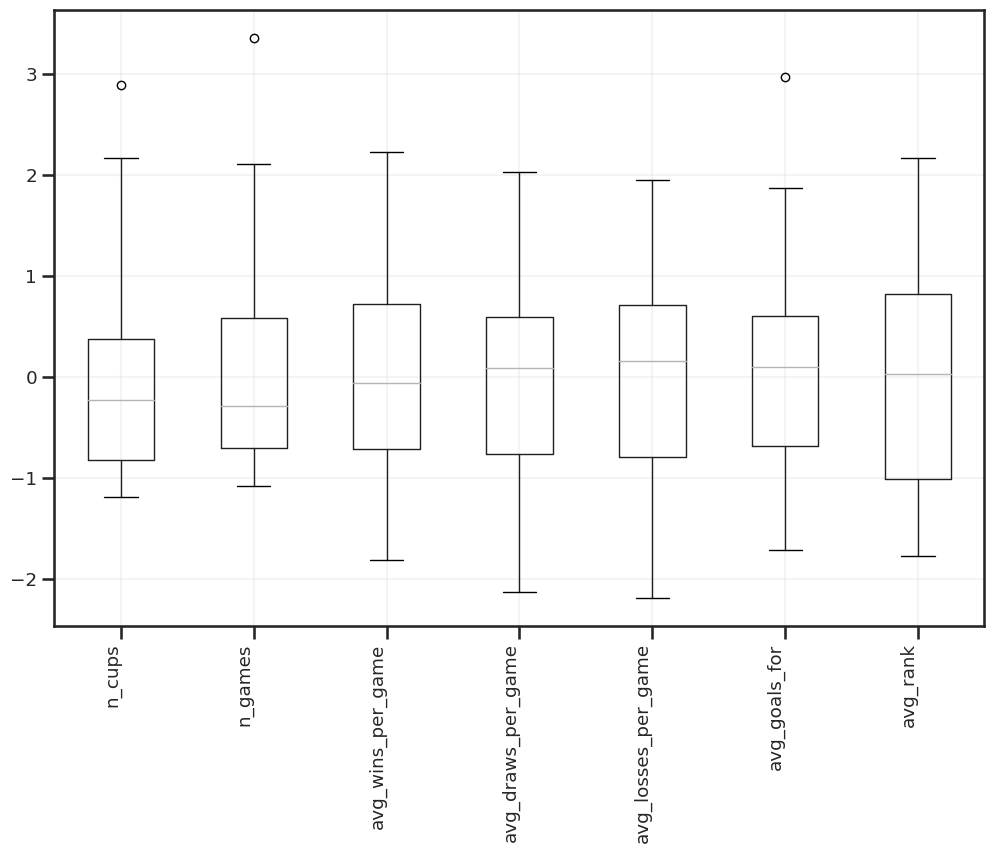

In [ ]:
df_teams_stats.apply(scale).boxplot()
plt.xticks(rotation=90, ha='right');

Limitando outliers para no máximo 3 desvios padrões:

In [ ]:
for col in df_teams_stats.columns:
  avg,std = df_teams_stats[col].agg(['mean','std'])
  df_teams_stats[col] = df_teams_stats[col].clip(lower=avg-3*std, upper=avg+3*std)

Normalizando valores para cada uma mesma escala (menor valor será -1 e maior 1):

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))

X = df_teams_stats.copy()
X[:] = scaler.fit_transform(X)

print('Scaled dataset')
display(X.head())

print('\nDataset stats')
display(X.describe())

Scaled dataset


,n_cups,n_games,avg_wins_per_game,avg_draws_per_game,avg_losses_per_game,avg_goals_for,avg_rank
Team,,,,,,,
Algeria,-1.000000,-1.000000,-0.432027,0.124881,0.371158,-0.655463,-0.705770
Argentina,0.529412,0.527618,0.477108,-0.329910,-0.412321,0.091155,0.463471
Australia,-0.882353,-0.932605,-0.837110,0.296473,0.735225,-0.812475,-0.873418
Austria,-0.647059,-0.640561,0.045928,-0.350674,0.073286,-0.206251,0.068758
Belgium,0.058824,-0.213726,-0.169721,-0.187756,0.232588,-0.228821,0.050157



Dataset stats


,n_cups,n_games,avg_wins_per_game,avg_draws_per_game,avg_losses_per_game,avg_goals_for,avg_rank
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,-0.417237,-0.480157,-0.103023,0.025020,0.056418,-0.268521,-0.098216
std,0.497119,0.480231,0.502087,0.486581,0.489534,0.432345,0.513462
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.823529,-0.820280,-0.457532,-0.340292,-0.328823,-0.561574,-0.610833
50%,-0.529412,-0.618096,-0.134109,0.067684,0.130024,-0.228821,-0.082794
75%,-0.235294,-0.191261,0.253766,0.310200,0.398739,-0.012108,0.318827
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualizando clusterização hierárquica:

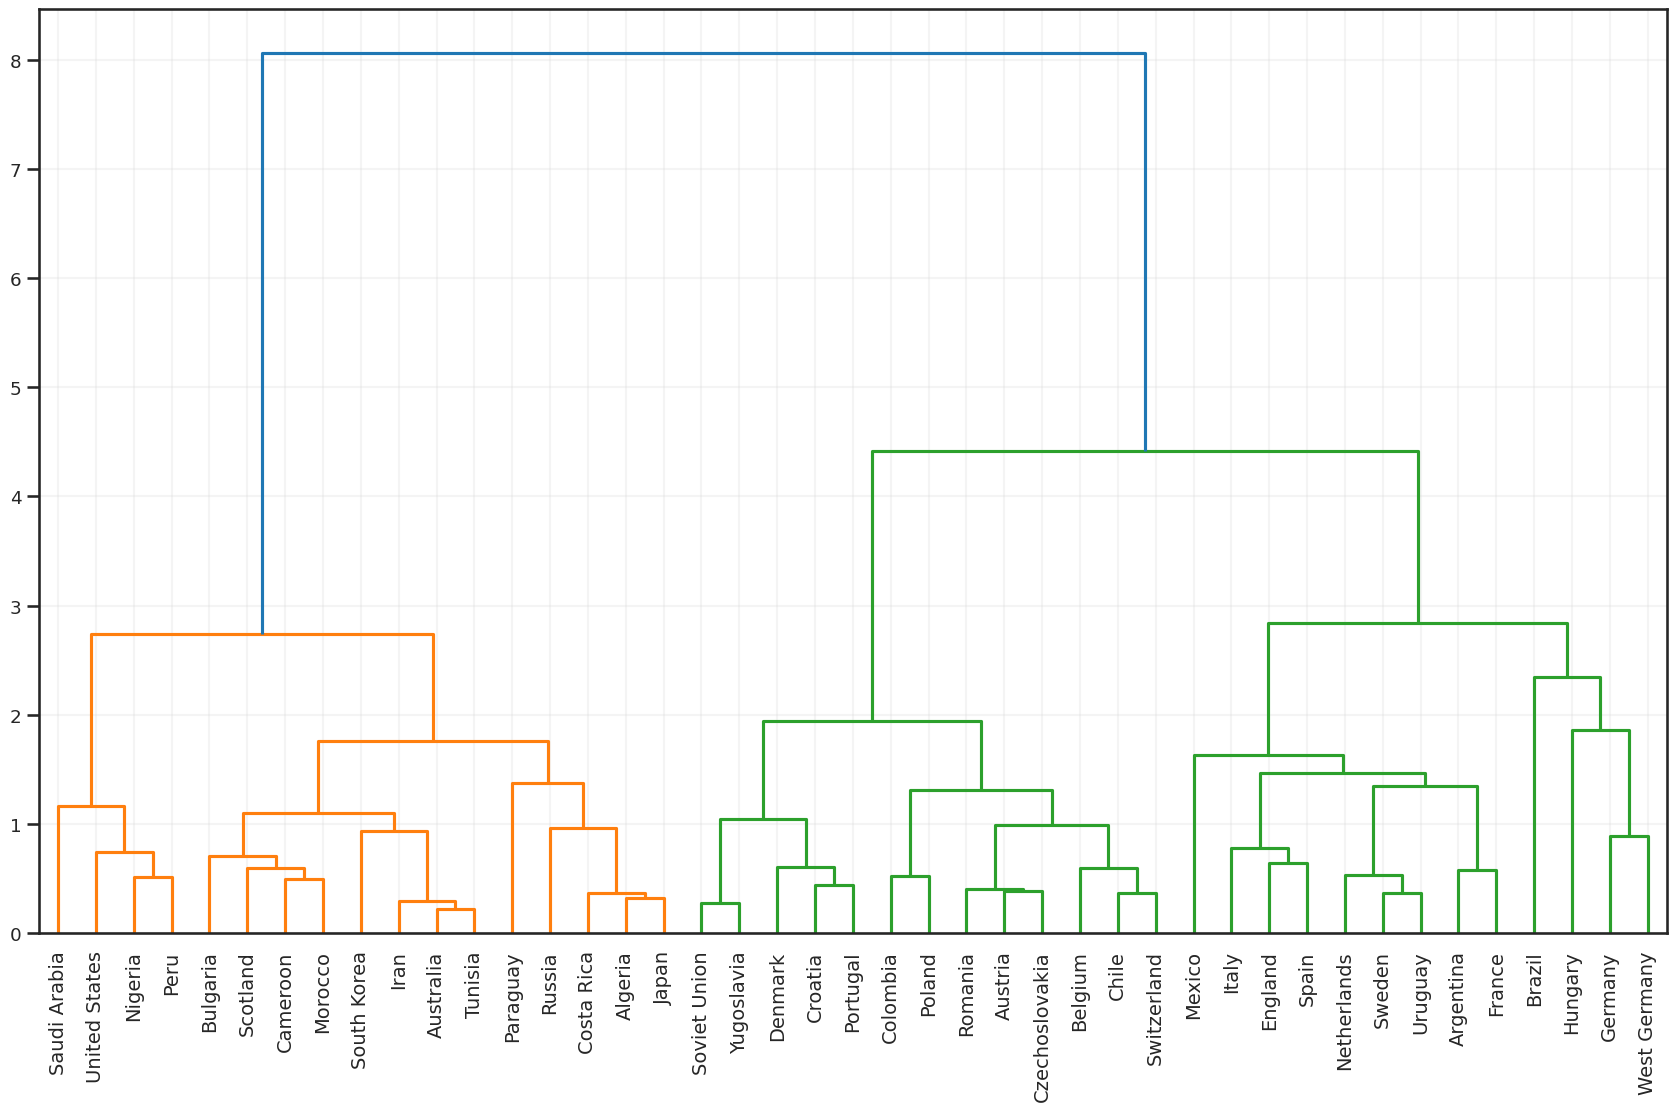

In [ ]:
plt.figure(figsize=(21,12))
Z = linkage(X, method='ward')
dendrogram_dict = dendrogram(Z, labels=X.index)
plt.xticks(fontsize=14)
plt.show()

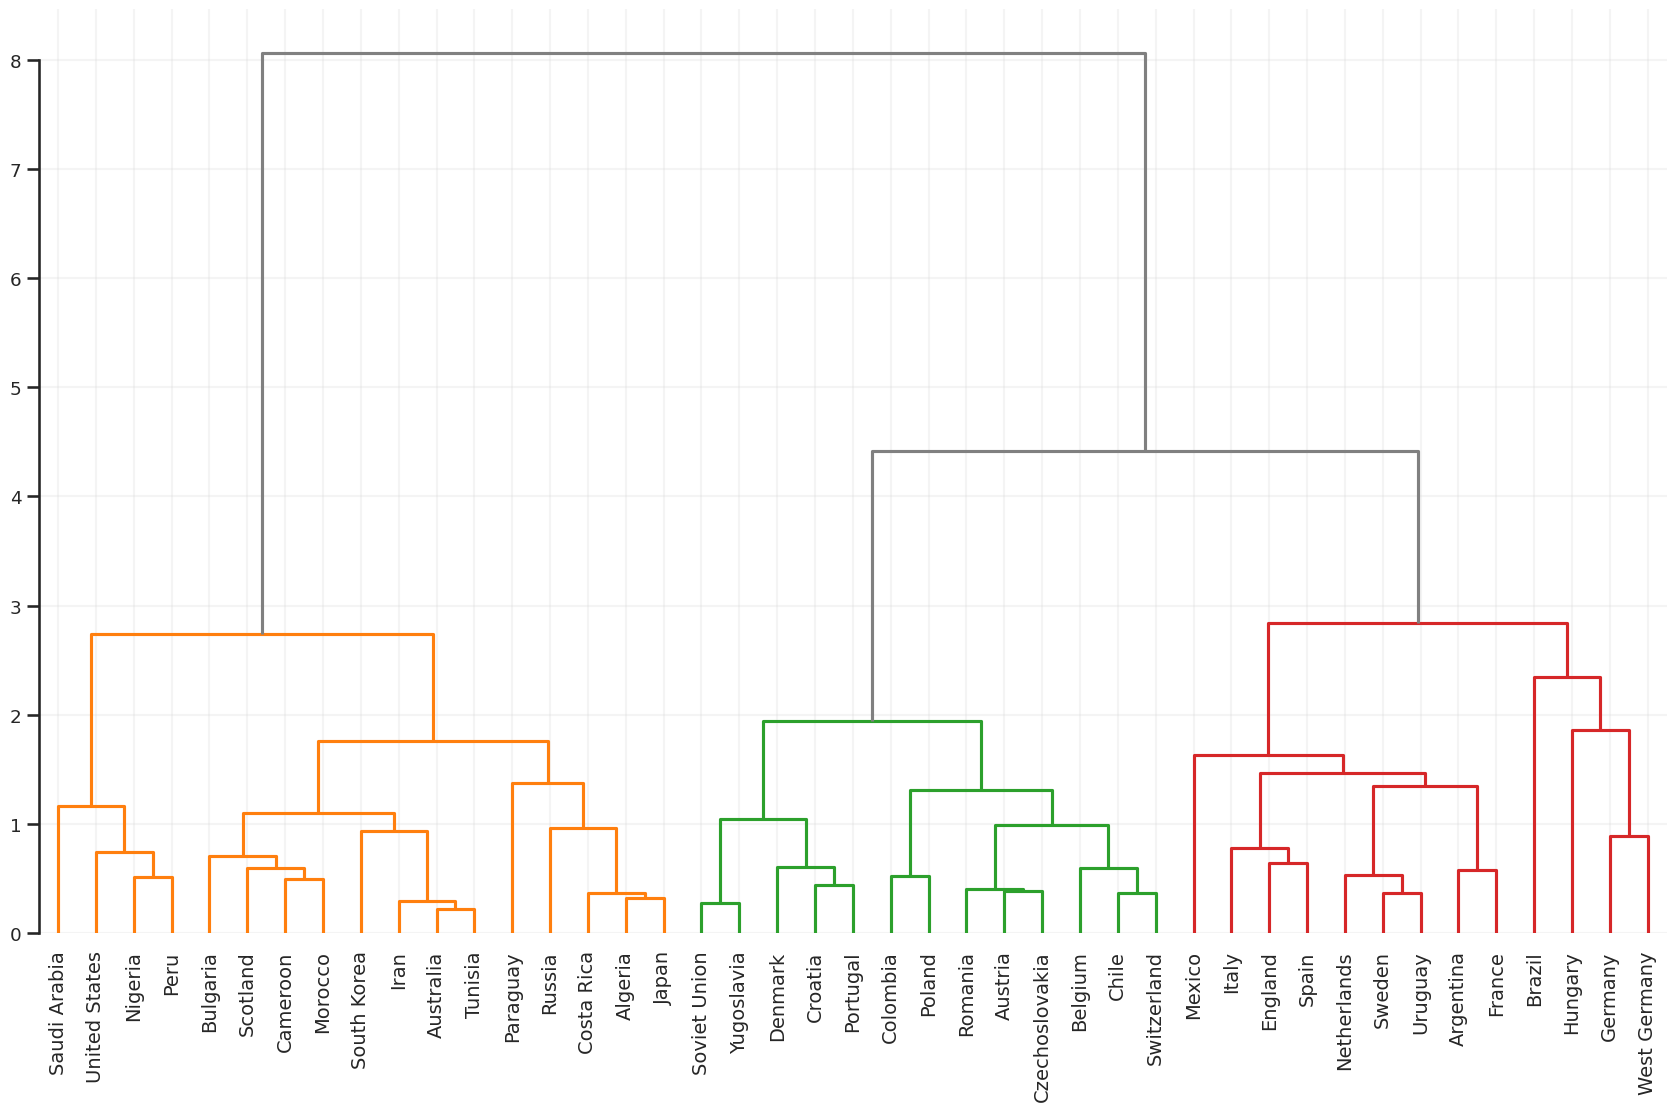

In [ ]:
plt.figure(figsize=(21,12))

Z = linkage(X, method='ward')
dendrogram_dict = dendrogram(Z, labels=X.index, color_threshold=4, above_threshold_color='gray')

sns.despine(bottom=True, trim=True)
plt.xticks(fontsize=14)
plt.show()

Testando diferentes métodos de agrupamento hierárquico bottom-up:

In [ ]:
@interact(method=['ward','complete','single','average','weighted','centroid','median'])
def hplot(method):
  plt.figure(figsize=(20,10))

  Z = linkage(X, method=method)
  dendrogram_dict = dendrogram(Z, labels=X.index)

  sns.despine(bottom=True, trim=True)
  plt.xticks(fontsize=14)
  plt.show()

interactive(children=(Dropdown(description='method', options=('ward', 'complete', 'single', 'average', 'weight…

AVALIANDO QUANTIDADE DE CLUSTERS:

In [ ]:
# Create list of dictionaries
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2,5):
  labels = fcluster(Z, k, criterion='maxclust')
  cluster_results_dict = {'k': k}
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

# Style dataframe
(
  pd.DataFrame(cluster_metrics_results)
  .set_index('k')
  .style.background_gradient(cmap='Blues')
)

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.379135,0.925606,35.924780
3,0.291832,1.125390,30.914918
4,0.298455,1.187906,25.836609


Considerando a métrica de silhouette, dois grupos são o que melhor descrevem os dados. Contudo, considerando as métricas de Davies Bouldin e Calinksi, 4 clusters são preferidos.

Considerando dois clusters:[texto do link](https:// [texto do link](https:// [texto do link](https:// [texto do link](https:// [texto do link](https://)))))

In [ ]:
labels = fcluster(Z, 2, criterion='maxclust')

(
  df_teams_stats.assign(cluster=labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='Reds', axis=1)
)

cluster,1,2
n_cups,6.117647,10.807692
n_games,20.352941,46.462597
avg_wins_per_game,0.182368,0.410880
avg_draws_per_game,0.248122,0.196721
avg_losses_per_game,0.569510,0.392399
avg_goals_for,0.938248,1.565356
avg_rank,0.287498,0.610239


Considerando dois clusters temos uma separação clara entre times que performaram ruim, com empates e muitas derrotas (grupo 1), e times que performaram bem (grupo 2).

Considerando quatro clusters:

In [ ]:
labels = fcluster(Z, 4, criterion='maxclust')

In [ ]:
# Interpretando valores normalizados de -1 a 1: (usando X)
(
  X.assign(cluster=labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='Reds', axis=1)
)

cluster,1,2,3,4
n_cups,-0.750865,-0.556561,0.241830,-0.029412
n_games,-0.834816,-0.616368,0.140721,0.072857
avg_wins_per_game,-0.600536,0.074107,0.201319,0.750970
avg_draws_per_game,0.281006,-0.200948,0.101046,-0.499582
avg_losses_per_game,0.481741,-0.029994,-0.315933,-0.632575
avg_goals_for,-0.654701,-0.145052,-0.099544,0.591270
avg_rank,-0.623276,0.063148,0.311570,0.686841


In [ ]:
# Interpretando valores reais: (usando df_teams_stats)
(
  df_teams_stats.assign(cluster=labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='Reds', axis=1)
)

cluster,1,2,3,4
n_cups,6.117647,7.769231,14.555556,12.250000
n_games,20.352941,30.076923,63.777778,60.756879
avg_wins_per_game,0.182368,0.369731,0.405060,0.557710
avg_draws_per_game,0.248122,0.189607,0.226273,0.153349
avg_losses_per_game,0.569510,0.440662,0.368667,0.288941
avg_goals_for,0.938248,1.438661,1.483344,2.161640
avg_rank,0.287498,0.542616,0.634946,0.774420


Considerando 4 grupos, também temos os times que performaram pior (grupo 1) e os que performaram melhor (grupo 4), contudo, temos uma divisão adicional mais próximo do grupo 4, que performou melhor, onde o grupo 3 teve mais participações e também mais empates, e o grupo 2 sem destaque específico, com métricas intermediárias.

Verificando os países que estão em cada cluster:

In [ ]:
for i in range(1,len(np.unique(labels))+1):
  list_of_teams = df_teams_stats.assign(cluster=labels).query(f'cluster=={i}').index.unique().tolist()
  print(f'Teams from cluster {i}: {list_of_teams}')

Teams from cluster 1: ['Algeria', 'Australia', 'Bulgaria', 'Cameroon', 'Costa Rica', 'Iran', 'Japan', 'Morocco', 'Nigeria', 'Paraguay', 'Peru', 'Russia', 'Saudi Arabia', 'Scotland', 'South Korea', 'Tunisia', 'United States']
Teams from cluster 2: ['Austria', 'Belgium', 'Chile', 'Colombia', 'Croatia', 'Czechoslovakia', 'Denmark', 'Poland', 'Portugal', 'Romania', 'Soviet Union', 'Switzerland', 'Yugoslavia']
Teams from cluster 3: ['Argentina', 'England', 'France', 'Italy', 'Mexico', 'Netherlands', 'Spain', 'Sweden', 'Uruguay']
Teams from cluster 4: ['Brazil', 'Germany', 'Hungary', 'West Germany']


In [ ]:
# QUANTIDADE DE TIMES POR COPA:

df_teams.Year.value_counts().sort_index()

1930    13
1934    16
1938    15
1950    13
1954    16
1958    16
1962    16
1966    16
1970    16
1974    16
1978    16
1982    24
1986    24
1990    24
1994    24
1998    32
2002    32
2006    32
2010    32
2014    32
2018    32
Name: Year, dtype: int64

In [ ]:
# VERIFICANDO JOGOS DA HUNGRIA:

df_teams.set_index('Team').loc['Hungary']

,Position,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points,Year,Win %,Draw %,Loss %,Avg Goals For,Avg Goals Against,Normalized Rank,Normalized Points,Century
Team,,,,,,,,,,,,,,,,,,
Hungary,6,2,1,0,1,5,4,1,2,1934,0.500000,0.000000,0.500000,2.500000,2.500000,0.748359,0.707877,20
Hungary,2,4,3,0,1,15,5,10,6,1938,0.750000,0.000000,0.250000,3.750000,3.750000,0.932166,0.293217,20
Hungary,2,5,4,0,1,27,10,17,8,1954,0.800000,0.000000,0.200000,5.400000,5.400000,0.932166,0.183807,20
Hungary,10,4,1,1,2,7,5,2,3,1958,0.250000,0.250000,0.500000,1.750000,1.750000,0.560175,0.585339,20
Hungary,5,4,2,1,1,8,3,5,5,1962,0.500000,0.250000,0.250000,2.000000,2.000000,0.794311,0.361050,20
Hungary,6,4,2,0,2,8,7,1,4,1966,0.500000,0.000000,0.500000,2.000000,2.000000,0.748359,0.456236,20
Hungary,15,3,0,0,3,3,8,−5,0,1978,0.000000,0.000000,1.000000,1.000000,1.000000,0.341357,0.937637,20
Hungary,14,3,1,1,1,12,6,6,3,1982,0.333333,0.333333,0.333333,4.000000,4.000000,0.381838,0.585339,20
Hungary,18,3,1,0,2,2,9,−7,2,1986,0.333333,0.000000,0.666667,0.666667,0.666667,0.247265,0.707877,20


In [ ]:
# VERIFICANDO JOGOS DO BRASIL:

df_teams.set_index('Team').loc['Brazil']

,Position,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points,Year,Win %,Draw %,Loss %,Avg Goals For,Avg Goals Against,Normalized Rank,Normalized Points,Century
Team,,,,,,,,,,,,,,,,,,
Brazil,6,2,1,0,1,5,2,3,2,1930,0.500000,0.000000,0.500000,2.500000,2.500000,0.748359,0.707877,20
Brazil,14,1,0,0,1,1,3,−2,0,1934,0.000000,0.000000,1.000000,1.000000,1.000000,0.381838,0.937637,20
Brazil,3,5,3,1,1,14,11,3,7,1938,0.600000,0.200000,0.200000,2.800000,2.800000,0.886214,0.234136,20
Brazil,2,6,4,1,1,22,6,16,9,1950,0.666667,0.166667,0.166667,3.666667,3.666667,0.932166,0.146608,20
Brazil,6,3,1,1,1,8,5,3,3,1954,0.333333,0.333333,0.333333,2.666667,2.666667,0.748359,0.585339,20
Brazil,1,6,5,1,0,16,4,12,11,1958,0.833333,0.166667,0.000000,2.666667,2.666667,0.978118,0.090810,20
Brazil,1,6,5,1,0,14,5,9,11,1962,0.833333,0.166667,0.000000,2.333333,2.333333,0.978118,0.090810,20
Brazil,11,3,1,0,2,4,6,−2,2,1966,0.333333,0.000000,0.666667,1.333333,1.333333,0.516411,0.707877,20
Brazil,1,6,6,0,0,19,7,12,12,1970,1.000000,0.000000,0.000000,3.166667,3.166667,0.978118,0.063457,20


In [ ]:
# VERIFICANDO JOGOS DA West Germany:

df_teams.set_index('Team').loc['West Germany']

,Position,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points,Year,Win %,Draw %,Loss %,Avg Goals For,Avg Goals Against,Normalized Rank,Normalized Points,Century
Team,,,,,,,,,,,,,,,,,,
West Germany,1,6,5,0,1,25,14,11,10,1954,0.833333,0.000000,0.166667,4.166667,4.166667,0.978118,0.120350,20
West Germany,4,6,2,2,2,12,14,−2,6,1958,0.333333,0.333333,0.333333,2.000000,2.000000,0.840263,0.293217,20
West Germany,7,4,2,1,1,4,2,2,5,1962,0.500000,0.250000,0.250000,1.000000,1.000000,0.702407,0.361050,20
West Germany,2,6,4,1,1,15,6,9,9,1966,0.666667,0.166667,0.166667,2.500000,2.500000,0.932166,0.146608,20
West Germany,3,6,5,0,1,17,10,7,10,1970,0.833333,0.000000,0.166667,2.833333,2.833333,0.886214,0.120350,20
West Germany,1,7,6,0,1,13,4,9,12,1974,0.857143,0.000000,0.142857,1.857143,1.857143,0.978118,0.063457,20
West Germany,6,6,1,4,1,10,5,5,6,1978,0.166667,0.666667,0.166667,1.666667,1.666667,0.748359,0.293217,20
West Germany,2,7,3,2,2,12,10,2,8,1982,0.428571,0.285714,0.285714,1.714286,1.714286,0.932166,0.183807,20
West Germany,2,7,3,2,2,8,7,1,8,1986,0.428571,0.285714,0.285714,1.142857,1.142857,0.932166,0.183807,20


In [ ]:
# VERIFICANDO JOGOS DA Germany:

df_teams.set_index('Team').loc['Germany']


,Position,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points,Year,Win %,Draw %,Loss %,Avg Goals For,Avg Goals Against,Normalized Rank,Normalized Points,Century
Team,,,,,,,,,,,,,,,,,,
Germany,3,4,3,0,1,11,8,3,6,1934,0.750000,0.000000,0.250000,2.750000,2.750000,0.886214,0.293217,20
Germany,10,2,0,1,1,3,5,-2,1,1938,0.000000,0.500000,0.500000,1.500000,1.500000,0.560175,0.818381,20
Germany,5,5,3,1,1,9,7,2,10,1994,0.600000,0.200000,0.200000,1.800000,1.800000,0.794311,0.120350,20
Germany,7,5,3,1,1,8,6,2,10,1998,0.600000,0.200000,0.200000,1.600000,1.600000,0.702407,0.120350,20
Germany,2,7,5,1,1,14,3,11,16,2002,0.714286,0.142857,0.142857,2.000000,2.000000,0.932166,0.026258,21
Germany,3,7,5,1,1,14,6,8,16,2006,0.714286,0.142857,0.142857,2.000000,2.000000,0.886214,0.026258,21
Germany,3,7,5,0,2,16,5,11,15,2010,0.714286,0.000000,0.285714,2.285714,2.285714,0.886214,0.032823,21
Germany,1,7,6,1,0,18,4,14,19,2014,0.857143,0.142857,0.000000,2.571429,2.571429,0.978118,0.006565,21
Germany,19,3,1,0,2,2,4,−2,3,2018,0.333333,0.000000,0.666667,0.666667,0.666667,0.225383,0.585339,21


## CONCLUSÃO

Separando em dois grupos, percebemos que a separação se dá por times com métricas boas e times com métricas ruins.

Separando em quatro, o time que performou melhor é quebrado, diferenciando-se:
- Aqueles que performaram melhor
- Aqueles com muitas participações, bastante empates, mas que também performaram bem.
- Aqueles com métricas intermediárias entre boas e ruins, contudo, ainda mais próximo das melhores métricas.

Interessantemente, cabe ressaltar que o Brasil, em conjunto com a Alemanha e Hungria, destacam-se em um grupo separado e caracterizado pela melhor média de gols por partida e posição na copa.

Cabe ressaltar que a Hungria iniciou bem na copa e manteve posições boas no início do século 20, mas caiu no final deste século enão teve mais nenhuma participação no século 21. Isto levanta a importância de olharmos cautelosamente a aplicação de filtros para que nosso modelo capture o que de fato queremos que capture, e para isso precisamos necessariamente da intervenção/raciocínio humano.

# JOGADORES

Outro dataset interessante para aplicar clusterização é dos jogadores das seleções.  
Vide este [dataset](https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset).